#### Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
import tensorflow as tf
from tensorflow.contrib import skflow

#### Provide path to dataset and read it to a Pandas DataFrame

In [2]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values= ['NA'])

#### Peeping into the Dataset

In [3]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic_df['survived'].mean()

0.3819709702062643

#### Simple Groupby Operations and Visualizations

In [5]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


In [6]:
class_sex_grouping = titanic_df.groupby(['pclass', 'sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

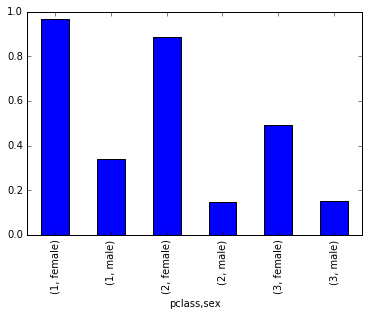

In [7]:
class_sex_grouping['survived'].plot.bar()

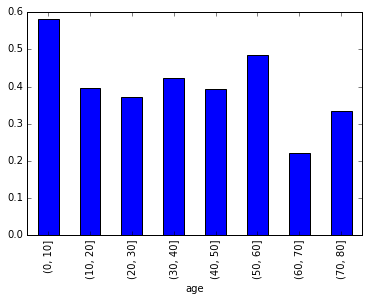

In [8]:
group_by_age = pd.cut(titanic_df['age'], np.arange(0, 90, 10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

In [9]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

#### Simple Modifications to Dataset

In [10]:
titanic_df = titanic_df.drop(['body', 'cabin', 'boat'], axis=1)

In [11]:
titanic_df['home.dest'] = titanic_df['home.dest'].fillna('NA')

In [12]:
titanic_df = titanic_df.dropna()

In [13]:
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [14]:
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name', 'ticket', 'home.dest'], axis=1)
    return processed_df

In [15]:
processed_df = preprocess_titanic_df(titanic_df)
processed_df.columns

Index([u'pclass', u'survived', u'sex', u'age', u'sibsp', u'parch', u'fare',
       u'embarked'],
      dtype='object')

#### Lets do some Predictive Analytics

In [16]:
X = processed_df.drop(['survived'], axis=1).values
y = processed_df['survived'].values

In [17]:
features = list(processed_df.drop(['survived'], axis=1).columns)
print features

[u'pclass', u'sex', u'age', u'sibsp', u'parch', u'fare', u'embarked']


In [18]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

In [19]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

In [20]:
clf_dt.fit(X_train, y_train)
clf_dt.score(X_test, y_test)

0.73684210526315785

In [21]:
from sklearn.tree import export_graphviz
import subprocess
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def visualize_tree(tree, feature_names):
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
        im = np.array(Image.open('dt.png'))
        plt.imshow(im,interpolation='nearest', aspect='auto')
    except:
        print "Could not run dot nor could not load image"

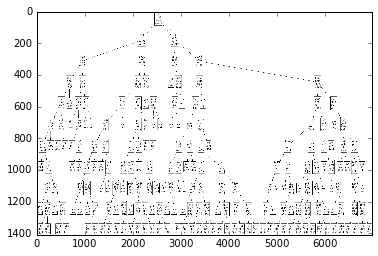

In [22]:
visualize_tree(clf_dt, features)

In [23]:
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size=0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf, X, y, cv=shuffle_validator)
    print("Accuracy: %0.4f (+/- %0.2f)" % (scores.mean(), scores.std()))

In [24]:
test_classifier(clf_dt)

Accuracy: 0.7751 (+/- 0.02)


In [25]:
%%time
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

Accuracy: 0.7816 (+/- 0.02)
CPU times: user 1.72 s, sys: 19.2 ms, total: 1.74 s
Wall time: 1.73 s


In [26]:
%%time
clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

Accuracy: 0.8201 (+/- 0.02)
CPU times: user 568 ms, sys: 2.57 ms, total: 571 ms
Wall time: 569 ms


In [27]:
%%time
eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.8062 (+/- 0.02)
CPU times: user 2.54 s, sys: 41.4 ms, total: 2.58 s
Wall time: 2.57 s


#### Use Skflow for simple hands-on into Deep Learning

In [28]:
%%time
tf_clf_dnn = skflow.TensorFlowDNNClassifier(hidden_units=[20, 40, 20], n_classes=2, 
                                            batch_size=256, steps=1000, learning_rate=0.05)
tf_clf_dnn.fit(X_train, y_train)
metrics.accuracy_score(y_test, tf_clf_dnn.predict(X_test))

CPU times: user 4.23 s, sys: 1.27 s, total: 5.5 s
Wall time: 4.36 s


In [29]:
passengers_set_1 = titanic_df[titanic_df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = titanic_df[titanic_df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = titanic_df[titanic_df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1, passengers_set_2, passengers_set_3])
testing_set = preprocess_titanic_df(passenger_set)

In [30]:
training_set = pd.concat([titanic_df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)

In [31]:
X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values

In [32]:
tf_clf_dnn.fit(X_train, y_train)
metrics.accuracy_score(y_test, tf_clf_dnn.predict(X_test))

0.71666666666666667

In [33]:
prediction = tf_clf_dnn.predict(X_test)
passenger_set[passenger_set.survived != prediction]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,S,"New York, NY"
10,1,0,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C,"New York, NY"
14,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,"Hessle, Yorks"
16,1,0,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,C,"Montreal, PQ"
20,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,S,"New York, NY"
333,2,1,"Ball, Mrs. (Ada E Hall)",female,36.0,0,0,28551,13.0000,S,"Bristol, Avon / Jacksonville, FL"
336,2,1,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S,"Norwich / New York, NY"
340,2,1,"Becker, Miss. Marion Louise",female,4.0,2,1,230136,39.0000,S,"Guntur, India / Benton Harbour, MI"
